# 1.1 - MODIS Geoprocess

* Create a ROI (Region of Interest)
* Create a POI (Period of Interest)
* Download MODIS Data
* Download GOES16 Data

In [1]:
import autoroot
import os
from dotenv import load_dotenv
from pathlib import Path
import earthaccess
import numpy as np
import xarray as xr
from dataclasses import dataclass
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# PLOTTING
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)



xr.set_options(
    keep_attrs=True, 
    display_expand_data=False, 
    display_expand_coords=False, 
    display_expand_data_vars=False, 
    display_expand_indexes=False
)
np.set_printoptions(threshold=10, edgeitems=2)

%load_ext autoreload
%autoreload 2

In [2]:
from rs_tools._src.data.modis import MODISFileName, MODIS_ID_TO_NAME, MODIS_NAME_TO_ID

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/data.py:519: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),


In [3]:
# select satellite name, "terra" or "aqua", "terra_cloud", "aqua_cloud"
satellite_name = "aqua"
# get satellite ID
satellite_id = MODIS_NAME_TO_ID[satellite_name]
# show
satellite_id

'MYD021KM'

In [8]:
modis_read_dir

PosixPath('/pool/usuarios/juanjohn/data/iti/modis_test_images_raw')

In [9]:
save_dir = Path(os.getenv("ITI_DATA_SAVEDIR"))
modis_read_dir = save_dir.joinpath("modis_test_images_raw")
modis_save_dir = save_dir.joinpath("modis_test_images_clean")
modis_read_dir.mkdir(parents=True, exist_ok=True)
modis_save_dir.mkdir(parents=True, exist_ok=True)

In [10]:
!ls $modis_read_dir

aqua
MOD021KM.A2020275.1200.061.2020276011934.hdf
MOD021KM.A2020275.1205.061.2020276011900.hdf
MOD021KM.A2020275.1340.061.2020276011930.hdf
MOD021KM.A2020275.1345.061.2020276011850.hdf
MOD021KM.A2020275.1515.061.2020276012851.hdf
MOD021KM.A2020275.1520.061.2020276012343.hdf


In [11]:
!ls $modis_save_dir

20201001150000_aqua.nc		 20201002140500_aqua.nc
202010011500_aqua_and_clouds.nc  202010021405_aqua_and_clouds.nc
20201001150500_aqua.nc		 20201002141000_aqua.nc
202010011505_aqua_and_clouds.nc  202010021410_aqua_and_clouds.nc
20201001164000_aqua.nc		 20201002154500_aqua.nc
202010011640_aqua_and_clouds.nc  202010021545_aqua_and_clouds.nc
20201001164500_aqua.nc		 20201002155000_aqua.nc
202010011645_aqua_and_clouds.nc  202010021550_aqua_and_clouds.nc
20201001182000_aqua.nc		 20201002172500_aqua.nc
202010011820_aqua_and_clouds.nc  202010021725_aqua_and_clouds.nc
20201001182500_aqua.nc		 20201002173000_aqua.nc
202010011825_aqua_and_clouds.nc  202010021730_aqua_and_clouds.nc


### MODIS Files

In [8]:
from dataclasses import dataclass
from rs_tools._src.utils.io import get_list_filenames
from rs_tools._src.data.modis import MODISFileName

In [12]:
from typing import Optional
from satpy import Scene
from rs_tools import get_modis_channel_numbers, MODIS_VARIABLES, MODIS_WAVELENGTHS
import pandas as pd


In [13]:
from rs_tools._src.geoprocessing.modis import MODIS_WAVELENGTHS, parse_modis_dates_from_file, format_modis_dates
from rs_tools._src.utils.io import get_list_filenames

In [14]:
# list of all .hdf files in the directory
all_modis_files = get_list_filenames(modis_read_dir, ".hdf")

# filter files for terra files ONLY ( our satellite id)
modis_files = list(filter(lambda x: satellite_id in x, all_modis_files))

len(all_modis_files), len(modis_files)

(30, 12)

MODIS files are typically ordered by date. 
So we can parse the dates in the strings using our helper function.
We will use this to grab all of the unique times.

In [15]:
# grab dates
unique_times = list(set(map(parse_modis_dates_from_file, modis_files)))
unique_times

['2020275.1820',
 '2020276.1410',
 '2020275.1500',
 '2020275.1825',
 '2020275.1505',
 '2020276.1730',
 '2020276.1545',
 '2020276.1405',
 '2020276.1725',
 '2020275.1645',
 '2020276.1550',
 '2020275.1640']

### Opening MODIS Files

In general, one can simply open it with xarray with the `netcdf4` back-end.
However, as we will see below, it's messy and very difficult to parse all of the relevant information

In [17]:
img = xr.open_dataset(modis_files[0], engine="netcdf4")
img

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
module 'numpy' has no attribute 'cumproduct'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 941MB
Dimensions:                                            (
                                                        2*nscans:MODIS_SWATH_Type_L1B: 406,
                                                        1KM_geo_dim:MODIS_SWATH_Type_L1B: 271,
                                                        Band_1KM_RefSB:MODIS_SWATH_Type_L1B: 15,
                                                        10*nscans:MODIS_SWATH_Type_L1B: 2030,
                                                        Max_EV_frames:MODIS_SWATH_Type_L1B: 1354,
                                                        ...
                                                        number of scans: 203,
                                                        number of 250m bands: 2,
                                                        detectors per 250m band: 40,
                                                        number of 500m bands: 5,
                                                        detectors per 500m band: 20,
                                                        number of 1km reflective bands: 15)
Coordinates: (4)
Dimensions without coordinates: 2*nscans:MODIS_SWATH_Type_L1B,
                                1KM_geo_dim:MODIS_SWATH_Type_L1B,
                                Band_1KM_RefSB:MODIS_SWATH_Type_L1B,
                                10*nscans:MODIS_SWATH_Type_L1B,
                                Max_EV_frames:MODIS_SWATH_Type_L1B,
                                Band_1KM_Emissive:MODIS_SWATH_Type_L1B,
                                ...
                                Band_500M:MODIS_SWATH_Type_L1B,
                                number of emissive bands,
                                detectors per 1km band, number of scans,
                                number of 250m bands, detectors per 250m band,
                                number of 500m bands, detectors per 500m band,
                                number of 1km reflective bands
Data variables: (27)
Attributes: (12/58)
    HDFEOSVersion:                                               HDFEOS_V2.19
    StructMetadata.0:                                            GROUP=SwathS...
    HDFEOS_FractionalOffset_10*nscans_MODIS_SWATH_Type_L1B:      0.0
    HDFEOS_FractionalOffset_Max_EV_frames_MODIS_SWATH_Type_L1B:  0.0
    CoreMetadata.0:                                              \nGROUP     ...
    ArchiveMetadata.0:                                           \nGROUP     ...
    ...                                                          ...
    Detector Quality Flag:                                       [0 0 ... 0 0]
    Detector Quality Flag2:                                      [0 0 ... 0 0]
    Earth-Sun Distance:                                          1.001002
    Solar Irradiance on RSB Detectors over pi:                   [511.5847 51...
    identifier_product_doi:                                      10.5067/MODI...
    identifier_product_doi_authority:                            http://dx.do...

An easier way to open this fil is using the `satpy` package. 
Under the hood, it will parse all of the relevant information from the `hdf5` file.

In [18]:
from satpy import Scene

**Warning**: You need to have the `pyhdf` package installed. 
For some reason the `h5py` package does not work...
If you installed everything from the `environment.yaml` file then it should be fine.

To use the `satpy` package, we simply need to load the channels that interest us.
In our case, we're interested in all of them.
So we will use our helper function to get the list of channels.

In [19]:
# scn.available_dataset_names()

In [21]:
from rs_tools.modis import get_modis_channel_numbers, CALIBRATION_CHANNELS

In [23]:
# load the channels
calibration = "radiance" # "radiance" # "reflectance" # "counts"
wishlist = CALIBRATION_CHANNELS[calibration]
scn = Scene(
    reader="modis_l1b",
    filenames=[modis_files[0]]
)
scn.load(wishlist, generate=False, calibration=calibration, resolution=1_000)


# convert to an xarray
ds = scn.to_xarray_dataset(datasets=wishlist)

ds

<xarray.Dataset> Size: 440MB
Dimensions:    (y: 2030, x: 1354)
Coordinates: (3)
Dimensions without coordinates: y, x
Data variables: (38)
Attributes: (12/15)
    platform_name:        EOS-Aqua
    modifiers:            ()
    calibration:          radiance
    sensor:               modis
    start_time:           2020-10-01 15:00:00
    end_time:             2020-10-01 15:05:00
    ...                   ...
    reader:               modis_l1b
    file_type:            hdf_eos_data_1000m
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    ancillary_variables:  []
    rows_per_scan:        10
    standard_name:        toa_outgoing_radiance_per_unit_wavelength

In [24]:
ds["1"].area

Shape: (2030, 1354)
Lons: <xarray.DataArray 'getitem-0af6d90798fe0420654577f3a1d5fd10' (y: 2030, x: 1354)> Size: 11MB
dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes: (12/14)
    standard_name:        longitude
    units:                degree
    platform_name:        EOS-Aqua
    sensor:               modis
    rows_per_scan:        10
    start_time:           2020-10-01 15:00:00
    ...                   ...
    name:                 longitude
    resolution:           1000
    modifiers:            ()
    _satpy_id:            DataID(name='longitude', resolution=1000, modifiers...
    long_name:            longitude
    ancillary_variables:  []
Lats: <xarray.DataArray 'getitem-072af275febfe6b9345a6586b5f7d1dc' (y: 2030, x: 1354)> Size: 11MB
dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes: (12/14)
    standard_name:        latitude
    units:                degree
    platform_name:        EOS-Aqua
    sensor:               modis
    rows_per_scan:        10
    start_time:           2020-10-01 15:00:00
    ...                   ...
    name:                 latitude
    resolution:           1000
    modifiers:            ()
    _satpy_id:            DataID(name='latitude', resolution=1000, modifiers=())
    long_name:            latitude
    ancillary_variables:  []

In [25]:
ds["1"].attrs["_satpy_id"]

DataID(name='1', wavelength=WavelengthRange(min=0.62, central=0.645, max=0.67, unit='µm'), resolution=1000, calibration=<3>, modifiers=())

As we can see, each dataarray is a **band** with an associated wavelength (and wavelength range).
We can already showcase what one band looks like.

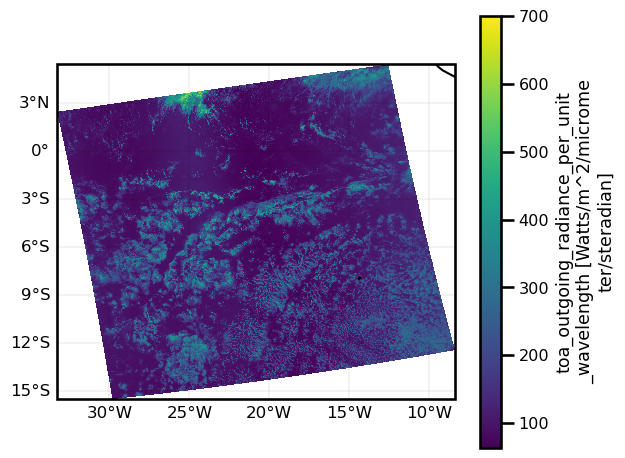

In [26]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

ds["3"].plot(
    ax=ax,
    x="longitude", y="latitude", 
    transform=ccrs.PlateCarree(),
)

ax.set(
    title=""
)
ax.coastlines()

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12} 
plt.tight_layout()
plt.show()

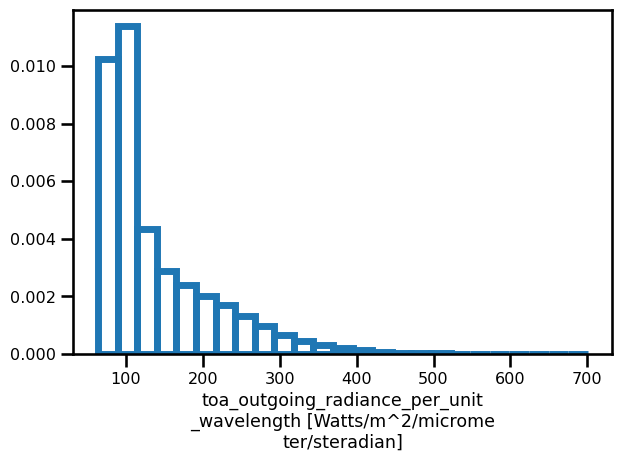

In [27]:
fig, ax = plt.subplots()
ds["3"].plot.hist(ax=ax, edgecolor="tab:blue", linewidth=5, fill=False, bins=25, density=True)
ax.set(
    title=""
)
plt.tight_layout()
plt.show()

#### Helper Function

In [28]:
from rs_tools.modis import load_modis_data_raw, preprocess_modis_raw, regrid_swath_to_regular

In [30]:
# load modis data
calibration = "radiance"
modis_swath = load_modis_data_raw(modis_files[0], calibration=calibration)



In [31]:
modis_swath

<xarray.Dataset> Size: 440MB
Dimensions:    (y: 2030, x: 1354)
Coordinates: (3)
Dimensions without coordinates: y, x
Data variables: (38)
Attributes: (12/15)
    platform_name:        EOS-Aqua
    modifiers:            ()
    calibration:          radiance
    sensor:               modis
    start_time:           2020-10-01 15:00:00
    end_time:             2020-10-01 15:05:00
    ...                   ...
    reader:               modis_l1b
    file_type:            hdf_eos_data_1000m
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    ancillary_variables:  []
    rows_per_scan:        10
    standard_name:        toa_outgoing_radiance_per_unit_wavelength

## Preprocess MODIS

We need to do some minimal preprocessing of these MODIS files because they are a bit messy with too much meta-data thats a bit difficult to read.
We have a handy script that is useful for getting some "minimal viably harmonized data".
In other words, we try to keep the most valuable information that can be analysis-ready for most users including machine learning.

#### Radiances

* Load Data with `SatPy`
* Keep Core Attributes
* Regrid to "Image"
* Collapse `xarrat.Dataset` into `xarray.DataArray`, `[B,C,H,W]`
* Correct Time Stamps

In [34]:
# preprocess_modis_raw??

In [96]:
# preprocess
modis_swath_clean = preprocess_modis_raw(modis_swath, calibration=calibration).compute()
modis_swath_clean

<xarray.Dataset> Size: 440MB
Dimensions:          (y: 2030, x: 1354, band: 38, time: 1, band_wavelength: 38)
Coordinates: (5)
Dimensions without coordinates: y, x
Data variables: (1)

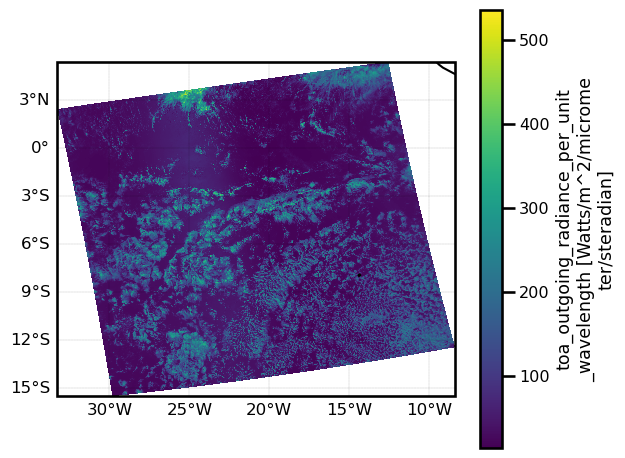

In [97]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

modis_swath_clean[calibration].isel(band=0).squeeze().plot(
    ax=ax,
    x="longitude", y="latitude", 
    transform=ccrs.PlateCarree(),
)

ax.set(
    title=""
)
ax.coastlines()

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12} 
plt.tight_layout()
plt.show()

### Regridding

In [98]:
# regrid to regular
resolution = 0.01
modis_grid = regrid_swath_to_regular(modis_swath_clean, calibration=calibration, resolution=resolution)
modis_grid

<xarray.Dataset> Size: 790MB
Dimensions:          (band: 38, latitude: 2092, longitude: 2485,
                      band_wavelength: 38, time: 1)
Coordinates: (6)
Data variables: (1)

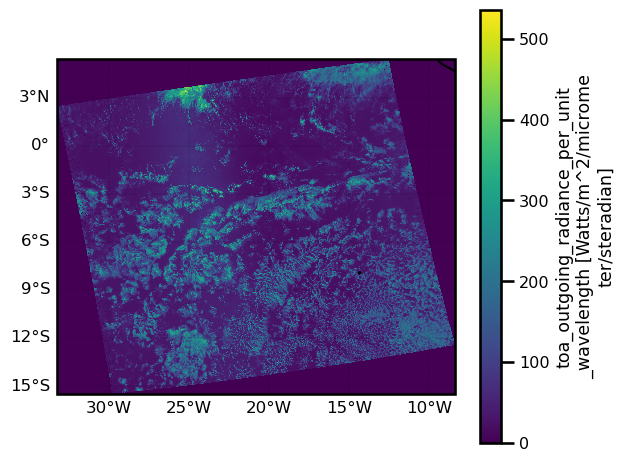

In [99]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

modis_grid[calibration].isel(band=0).squeeze().plot(
    ax=ax,
    x="longitude", y="latitude", 
    transform=ccrs.PlateCarree(),
)

ax.set(
    title=""
)
ax.coastlines()

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12} 
plt.tight_layout()
plt.show()

## Saving

Our MODIS swath data is a `swath` image. 
In otherwords, it is a curvilinear grid.
This is a weird grid which has weird geometries.
So, xarray is the only option to save this without the option of reprojection.

In [100]:
from rs_tools._src.data.modis import MODISRawFiles

In [101]:
modis_read_dir

PosixPath('/pool/usuarios/juanjohn/data/iti/modis_test_images_raw')

In [103]:
# load modis files
modis_filer = MODISRawFiles(modis_read_dir)

# load all modis files
modis_list_of_file_objs = modis_filer.modis_file_obj

# filter for only satellites
modis_list_of_file_objs = list(
    filter(lambda x: MODIS_NAME_TO_ID[satellite_name] in x.satellite_id, modis_list_of_file_objs)
)
len(modis_list_of_file_objs)

12

In [104]:
from tqdm.auto import tqdm

calibration = "radiance"
pbar = tqdm(modis_list_of_file_objs)

for ifile in pbar:
    pbar.set_description(f"Satellite - {satellite_name} | Starting time: {ifile.datetime_acquisition}...")
    # skip if the satellite isn't correct
    if satellite_name != ifile.satellite_name:
        continue

    # load modis swath
    pbar.set_description(f"Loading MODIS SWATH...")
    modis_swath = load_modis_data_raw(ifile.full_path, calibration=calibration)

    # preprocess modis swath
    pbar.set_description(f"Cleaning Data...")
    modis_swath_clean = preprocess_modis_raw(modis_swath, calibration=calibration).compute()

    # regrid

    
    break

  0%|          | 0/12 [00:00<?, ?it/s]

In [42]:
modis_date = parse_modis_dates_from_file(modis_files[0])
# convert time to something more legible
itime_name = datetime.strftime(modis_date, "%Y%j.%H%M")

TypeError: descriptor 'strftime' for 'datetime.date' objects doesn't apply to a 'str' object

In [24]:
modis_clean_dir.mkdir(parents=True, exist_ok=True)
modis_grid.to_netcdf(modis_clean_dir.joinpath("modis_grid.nc"), engine="netcdf4")

In [26]:
!ls $modis_clean_dir

modis_grid.nc  modis_swath.nc


## Preprocess MODIS

We need to do some minimal preprocessing of these MODIS files because they are a bit messy with too much meta-data thats a bit difficult to read.
We have a handy script that is useful for getting some "minimal viably harmonized data".
In other words, we try to keep the most valuable information that can be analysis-ready for most users including machine learning.

#### Radiances

* Load Data with `SatPy`
* Keep Core Attributes
* Collapse `xarrat.Dataset` into `xarray.DataArray`, `[B,C,H,W]`
* Correct Time Stamps

In [16]:
from rs_tools._src.geoprocessing.modis.geoprocessor_modis import preprocess_modis_image_radiances

# # peak into the function
# preprocess_modis_image_radiances??

In [17]:
modis_swath = preprocess_modis_image_radiances(modis_files[0]).compute()
modis_swath

<xarray.Dataset> Size: 440MB
Dimensions:          (y: 2030, x: 1354, band: 38, time: 1, band_wavelength: 38)
Coordinates: (5)
Dimensions without coordinates: y, x
Data variables: (1)

## Saving

Our MODIS swath data is a `swath` image. 
In otherwords, it is a curvilinear grid.
This is a weird grid which has weird geometries.
So, xarray is the only option to save this without the option of reprojection.

In [24]:
modis_clean_dir.mkdir(parents=True, exist_ok=True)
modis_swath.to_netcdf(modis_clean_dir.joinpath("modis_swath.nc"), engine="netcdf4")

In [26]:
!ls $modis_clean_dir

modis_grid.nc  modis_swath.nc


#### Other Options



We can also opt to save it as `geotiff`.
However, we need to transform it into an image.
The simplest way is to transform it into a rectilinear lat-lon grid.
In a future tutorial, we will look into how we can accomplish that more effectively.

### Dataclass

* MODIS Raw Files
* MODIS Radiances (Aqua, Terra)
* MODIS Clouds (Aqua, Terra)
* Geoprocessor - clean, regrid, etc

## Script

We have some automated downloading scripts that can help us save a few steps.

In [105]:
from rs_tools._src.geoprocessing.modis.geoprocessor_modis_refactor import geoprocess
# from rs_tools._src.data.modis.downloader_terra import download as terra_downloader


In [106]:
!ls $modis_read_dir/aqua

CM  L1b


In [107]:
from IPython.utils import io

with io.capture_output() as captured:
    geoprocess(
        satellite="aqua", 
        calibration="radiance",
        read_path=modis_read_dir,
        save_path=modis_clean_dir,
    )

NameError: name 'modis_clean_dir' is not defined

In [45]:
!ls $modis_clean_dir

20201001150000_aqua.nc	20201001182500_aqua.nc	20201002172500_aqua.nc
20201001150500_aqua.nc	20201002140500_aqua.nc	20201002173000_aqua.nc
20201001164000_aqua.nc	20201002141000_aqua.nc	modis_grid.nc
20201001164500_aqua.nc	20201002154500_aqua.nc	modis_swath.nc
20201001182000_aqua.nc	20201002155000_aqua.nc


## Command-Line Configuration

We also have some command-line scripts that are even more free.

In [37]:
!cat $autoroot.root/config/example/geoprocess.yaml

# PATH WITH RAW DATA
read_path: data

# PATH FOR SAVING GEOPROCESSED DATA
save_path: data

defaults:
  - _self_


In [38]:
!sed -n 10,15p $autoroot.root/config/example/satellite/aqua.yaml 

geoprocess:
  _target_: rs_tools._src.geoprocessing.modis.geoprocessor_modis.geoprocess
  read_path: ${read_path}/aqua/raw
  save_path: ${save_path}/aqua/geoprocessed
  satellite: aqua

